In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42

Get my own dataset

In [4]:
cmt_pos = pd.read_csv('../../data/prepared/no_trans_stem_pos.csv')
cmt_neg = pd.read_csv('../../data/prepared/no_trans_stem_neg.csv')

In [5]:
X, Y, vocab_size, emdedding_size = get_data(cmt_pos, cmt_neg, 0)
vectors = get_vectors(0).vectors
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 965, 0: 965})
Test labels:  Counter({1: 414, 0: 414})


In [6]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

In [8]:
adamOptimizer = Adam(lr=0.0001)

In [9]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [10]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [11]:
def run_test(model_func, Xtrain, ytrain, X_test, y_test, embedding_layer):
    results = []
    histories = []
    best_model = None
    best_acc = 0
    for train_index, val_index in sk.split(X_train, y_train):
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xt, yt, validation_data=(Xv, yv), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose = 0, batch_size = 16)
        if best_acc < acc:
            best_model = model
        results.append([loss, acc])
    results = np.array(results)
    return results, histories, model

In [12]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [13]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation without pretrained word vectors

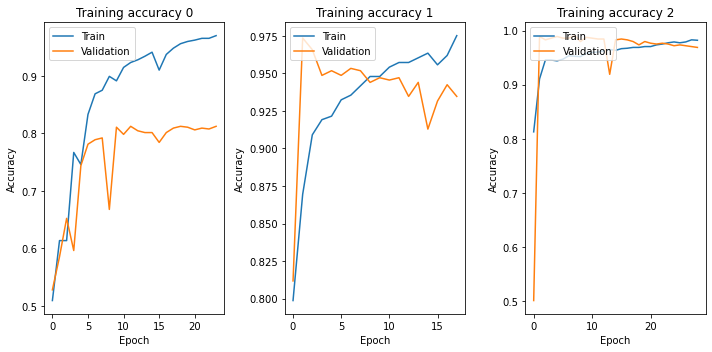

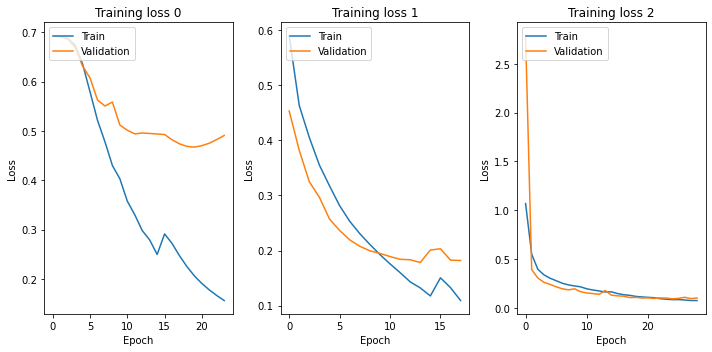

Average model 1 accuracy of cross validation on unseen data: 0.8035
The best perfoming model statistics with class predictions: 
Accuracy: 0.8164
Precision: 0.7991
Recall: 0.8454
F1 score: 0.8216
Confusion matrix:
               pred:positive  pred:negative
true:positive            326             88
true:negative             64            350


In [14]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation without pretrained word vectors

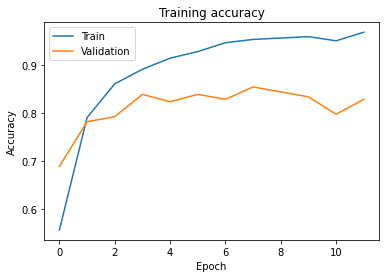

Model statistics with class predictions: 
Accuracy: 0.8116
Precision: 0.7905
Recall: 0.8478
F1 score: 0.8182
Confusion matrix:
               pred:positive  pred:negative
true:positive            321             93
true:negative             63            351


In [32]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [33]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


First model cross-validation with pretrained word vectors

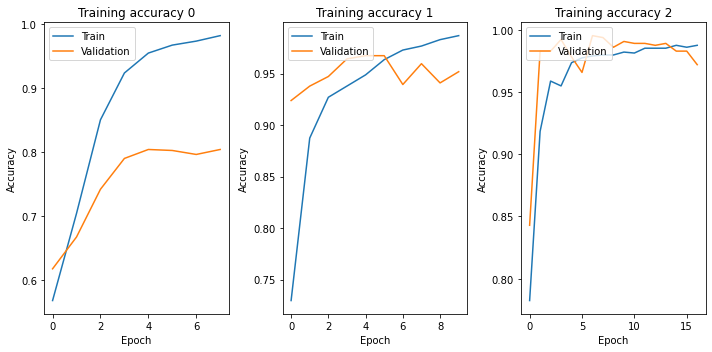

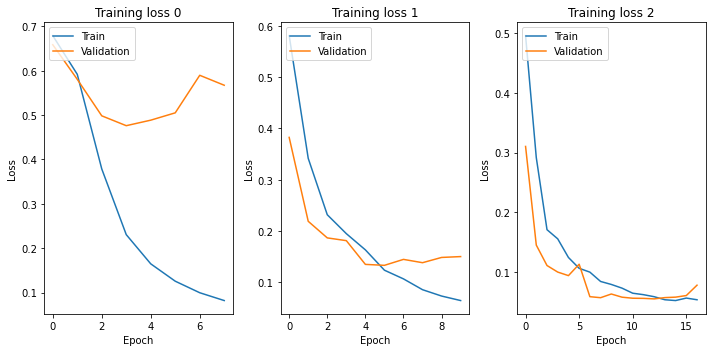

Average model 1 accuracy of cross validation on unseen data: 0.8132
The best perfoming model statistics: 
Accuracy: 0.8188
Precision: 0.7973
Recall: 0.8551
F1 score: 0.8252
Confusion matrix:
               pred:positive  pred:negative
true:positive            324             90
true:negative             60            354


In [16]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation with pretrained word vectors

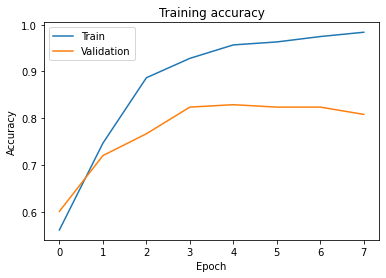

Model statistics with class predictions: 
Accuracy: 0.8213
Precision: 0.8037
Recall: 0.8502
F1 score: 0.8263
Confusion matrix:
               pred:positive  pred:negative
true:positive            328             86
true:negative             62            352


In [34]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [35]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


# Model 2

In [39]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

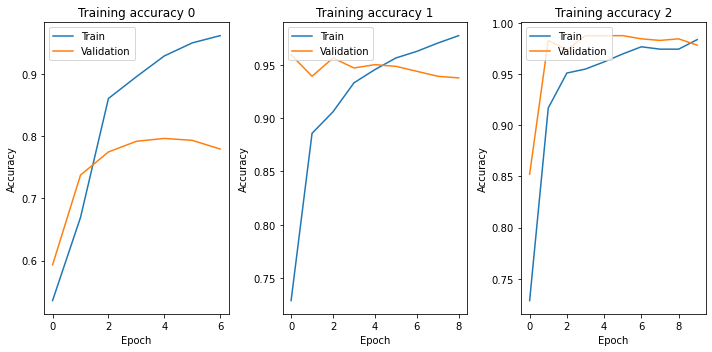

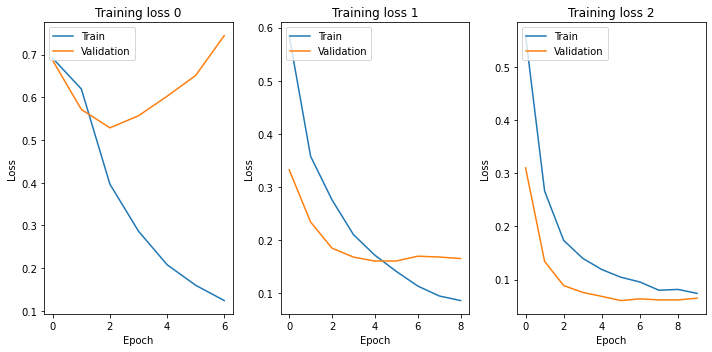

Average model 2 accuracy of cross validation on unseen data: 0.8023
The best perfoming model statistics with class predictions: 
Accuracy: 0.8128
Precision: 0.8005
Recall: 0.8333
F1 score: 0.8166
Confusion matrix:
               pred:positive  pred:negative
true:positive            328             86
true:negative             69            345


In [19]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation without pretrained word vectors

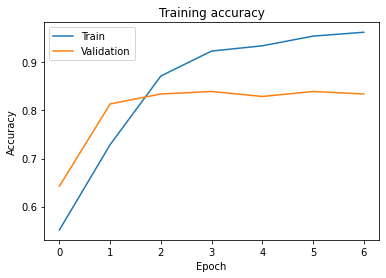

Model statistics with class predictions: 
Accuracy: 0.8080
Precision: 0.7931
Recall: 0.8333
F1 score: 0.8127
Confusion matrix:
               pred:positive  pred:negative
true:positive            324             90
true:negative             69            345


In [37]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [38]:
# Save best performing model (weights, architecture)
model.save('../../models/models/lstm2-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


Second model cross-validation with pretrained word vectors

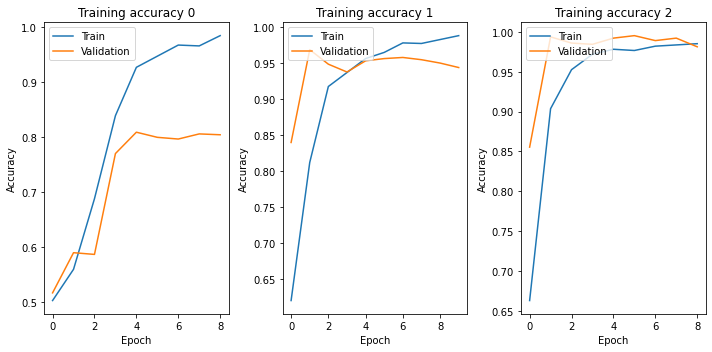

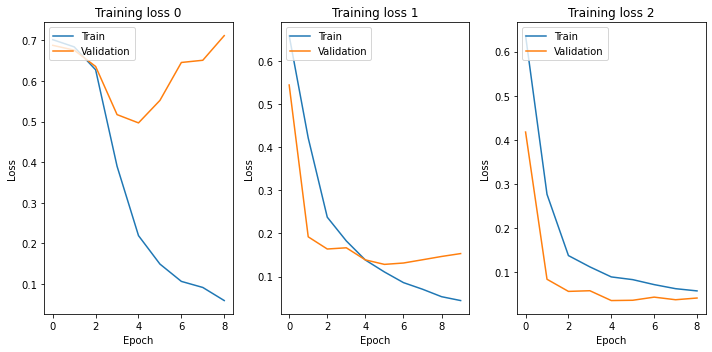

Average model 2 accuracy of cross validation on unseen data: 0.8144
The best perfoming model statistics: 
Accuracy: 0.8297
Precision: 0.8491
Recall: 0.8019
F1 score: 0.8248
Confusion matrix:
               pred:positive  pred:negative
true:positive            355             59
true:negative             82            332


In [21]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation with pretrained word vectors

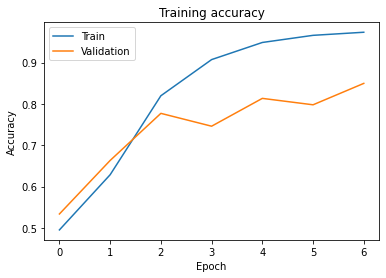

Model statistics with class predictions: 
Accuracy: 0.8237
Precision: 0.8384
Recall: 0.8019
F1 score: 0.8198
Confusion matrix:
               pred:positive  pred:negative
true:positive            350             64
true:negative             82            332


In [41]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[vectors], trainable=True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [42]:
model.save('../../models/models/lstm2-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


# Model architecture tests on IMDB dataset

In [43]:
# IMDB dataset
from keras.datasets import imdb

In [44]:
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

## Model 1

First model cross-validation

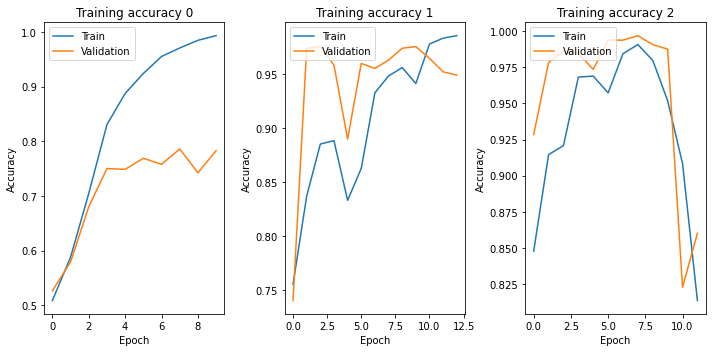

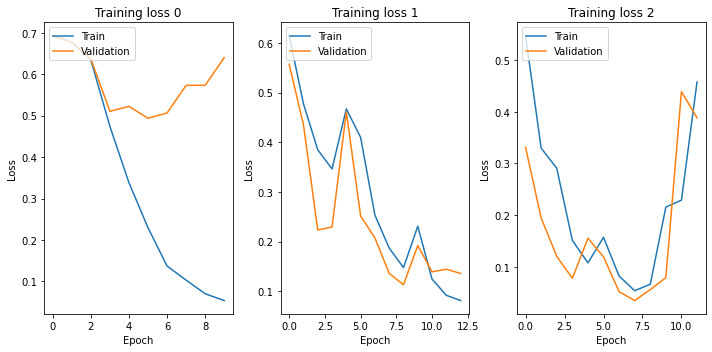

Average model 1 accuracy of cross validation on unseen IMDB data: 0.7627
The best perfoming model statistics: 
Accuracy: 0.7022
Precision: 0.7743
Recall: 0.5709
F1 score: 0.6572
Confusion matrix:
               pred:positive  pred:negative
true:positive          10420           2080
true:negative           5364           7136


In [45]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_1, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 1 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation

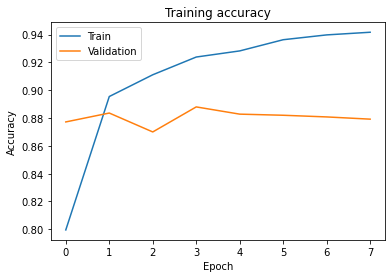

Model statistics with class predictions: 
Accuracy: 0.8740
Precision: 0.8594
Recall: 0.8944
F1 score: 0.8766
Confusion matrix:
               pred:positive  pred:negative
true:positive          10671           1829
true:negative           1320          11180


In [47]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_1(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model cross-validation

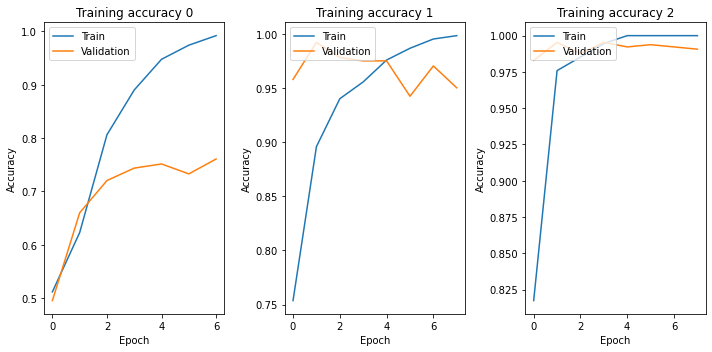

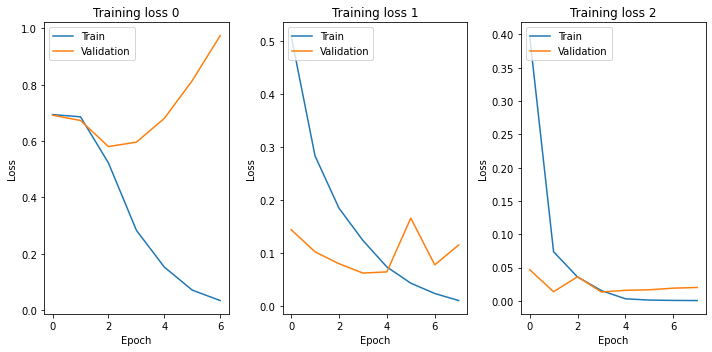

Average model 2 accuracy of cross validation on unseen IMDB data: 0.7680
The best perfoming model statistics: 
Accuracy: 0.7763
Precision: 0.7764
Recall: 0.7762
F1 score: 0.7763
Confusion matrix:
               pred:positive  pred:negative
true:positive           9705           2795
true:negative           2797           9703


In [46]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_2, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 2 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation

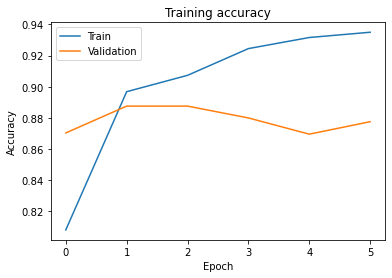

Model 2 statistics with class predictions: 
Accuracy: 0.8746
Precision: 0.8749
Recall: 0.8742
F1 score: 0.8745
Confusion matrix:
               pred:positive  pred:negative
true:positive          10937           1563
true:negative           1573          10927


In [48]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=16, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model 2 statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)